# Week 8 - MINST Bagging

*Using the MNIST hand-written character dataset, use bagging to improve your method. Submit your code and a summary of the results. How much better/worse are your results?*

### 1. MNIST character recognition without bagging

This script is modified from: https://github.com/Vict0rSch/deep_learning/tree/master/keras/feedforward

In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import np_utils
import keras.callbacks as cb
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.datasets import mnist
from keras.layers import Merge

Using Theano backend.


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

In [4]:
def load_data():
    print 'Loading data...'
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train /= 255
    X_test /= 255

    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)

    X_train = np.reshape(X_train, (60000, 784))
    X_test = np.reshape(X_test, (10000, 784))

    print 'Data loaded.'
    return [X_train, X_test, y_train, y_test]


In [5]:
def init_model():
    start_time = time.time()
    print 'Compiling Model ... '
    model = Sequential()
    model.add(Dense(500, input_dim=784))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(300))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    rms = RMSprop()
    model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])
    print 'Model compiled in {0} seconds'.format(time.time() - start_time)
    return model

In [6]:
def run_network(data=None, model=None, epochs=20, batch=256):
    try:
        start_time = time.time()
        if data is None:
            X_train, X_test, y_train, y_test = load_data()
        else:
            X_train, X_test, y_train, y_test = data

        if model is None:
            model = init_model()

        history = LossHistory()

        print 'Training model...'
        model.fit(X_train, y_train, nb_epoch=epochs, batch_size=batch,
                  callbacks=[history], validation_data=(X_test, y_test), verbose=0)

        print "Training duration : {0}".format(time.time() - start_time)
        score = model.evaluate(X_test, y_test, batch_size=16, verbose = 0)

        print "Network's test score [loss, accuracy]: {0}".format(score)
        return model, history.losses, score
    
    except KeyboardInterrupt:
        print ' KeyboardInterrupt'
        return model, history.losses

In [7]:
model, losses, score = run_network()

Loading data...
Data loaded.
Compiling Model ... 
Model compiled in 0.703524112701 seconds
Training model...
Training duration : 217.73646903
Network's test score [loss, accuracy]: [0.085744078117444, 0.98419999999999996]


In [8]:
no_bagging_score = score[1]

/usr/lib/pymodules/python2.7/matplotlib/figure.py:371: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


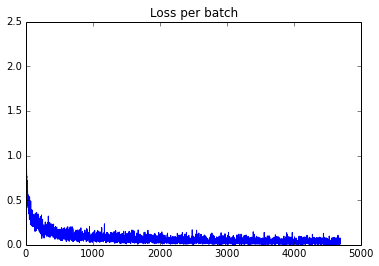

In [9]:
def plot_losses(losses):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(losses)
    ax.set_title('Loss per batch')
    fig.show()

plot_losses(losses)

### 2. Bagging Implementation 


In [10]:
def bagging_generator(X_train, y_train):
    obs_length = len(X_train)
    random_indices = np.random.randint(low = 0, high = obs_length, size = obs_length)
    
    X_train_bag = X_train[random_indices]
    y_train_bag = y_train[random_indices]
    
    print random_indices[1]
    return X_train_bag, y_train_bag    

In [11]:
def merge_models(model_record):
    print 'Compiling Final Model ... '
    merged = Merge(model_record, mode='ave')
    final_model = Sequential()
    final_model.add(merged)
    rms = RMSprop()
    final_model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])
    
    return final_model

In [12]:
def run_network_bagging(data=None, model=None, epochs=20, batch=256, bags=10):
    try:
        start_time = time.time()
        if data is None:
            X_train, X_test, y_train, y_test = load_data()
        else:
            X_train, X_test, y_train, y_test = data

        if model is None:
            model = init_model()

        history = LossHistory()
        
        model_record = []
        score_record = []

        for i in range(0,(bags-1)):
            
            print i
            X_train_bag, y_train_bag = bagging_generator(X_train, y_train)
        
            print 'Training model...'
            model.fit(X_train_bag, y_train_bag, nb_epoch=epochs, batch_size=batch,
                      callbacks=[history], validation_data=(X_test, y_test), verbose=0)
            
            model_record.append(model)
     
            print "Training duration : {0}".format(time.time() - start_time)
        
            score = model.evaluate(X_test, y_test, batch_size=16, verbose = 0)
            score_record.append(score)
            print "Bag model's test score [loss, accuracy]: {0}".format(score)
            
        return model_record, X_train, y_train, X_test, y_test
        
    except KeyboardInterrupt:
        print ' KeyboardInterrupt'
        return model, history.losses

In [13]:
bagging_models, X_train, y_train, X_test, y_test = run_network_bagging()

Loading data...
Data loaded.
Compiling Model ... 
Model compiled in 0.238909006119 seconds
0
22732
Training model...
Training duration : 221.292720795
Bag model's test score [loss, accuracy]: [0.11330453635259428, 0.97989999999999999]
1
51930
Training model...
Training duration : 454.82444191
Bag model's test score [loss, accuracy]: [0.11305700443888131, 0.9839]
2
17515
Training model...
Training duration : 705.322721958
Bag model's test score [loss, accuracy]: [0.13116109745593593, 0.98329999999999995]
3
10563
Training model...
Training duration : 952.29229188
Bag model's test score [loss, accuracy]: [0.12333743373101917, 0.98419999999999996]
4
9701
Training model...
Training duration : 1199.21475792
Bag model's test score [loss, accuracy]: [0.13115552903754446, 0.98540000000000005]
5
7207
Training model...
Training duration : 1450.59256387
Bag model's test score [loss, accuracy]: [0.15064788035066679, 0.98209999999999997]
6
1849
Training model...
Training duration : 1701.20073581
Bag

In [14]:
final_model = merge_models(bagging_models)

Compiling Final Model ... 


In [15]:
def final_model_eval(final_model, X_train, y_train, X_test, y_test):
        
    final_model.fit(X_train, y_train, nb_epoch=3, batch_size=256, validation_data=(X_test, y_test), verbose=0)

    final_score =  final_model.evaluate(X_test, y_test, batch_size=16, verbose = 0)
    print "Using bagging, the model's test score is [loss, accuracy]: {0}".format(final_score)

    return final_score

In [16]:
final_score = final_model_eval(final_model, X_train, y_train, X_test, y_test)

Using bagging, the model's test score is [loss, accuracy]: [0.15686859648802912, 0.98319999999999996]


In [17]:
print final_score[1]

0.9832


In [18]:
print no_bagging_score

0.9842


The original model already has an extremely high score. The use of bagging does not effect the score very much. This may be because the MNIST dataset does not have a high variance, so bagging is not an ensemble technique that is required. 